In [13]:
import mne
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA

from sklearn.metrics import confusion_matrix
import itertools

import os

from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)

In [14]:
"""
GOAL: Use all data for language and non-language (not restrited to visual)
      Optimize RandomForest paramter using GridSearchCV
      
      
"""

'\nGOAL: Use all data for language and non-language (not restrited to visual)\n      Optimize RandomForest paramter using GridSearchCV\n      \n      \n'

In [15]:
def importantChannelFinder(features,target,binary_epoch,return1_or_2):
    forest = RandomForestClassifier(n_estimators=100,random_state=0)
    
    #cv = StratifiedKFold(n_splits=1,shuffle=True)
    scores = []
 
    
    X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.25, random_state=42)
      
    twoD_X_train = Vectorizer().fit_transform(X_train)
    twoD_X_train = StandardScaler().fit_transform(twoD_X_train)
    forest.fit(twoD_X_train,y_train)

    """manipulate array to 125 features"""
    impt = []
    for e in forest.feature_importances_:
        impt.append(e)
        
    #print("shape of important feat array: ",np.array(impt).shape)
    feat_importnt_allchannels = []
    channel_importance = []
    time = binary_epoch.get_data().shape[2]
    channel_times_time = binary_epoch.get_data().shape[1] * binary_epoch.get_data().shape[2]
    for i in range(0,32125,257):
        #print(i)
        hold = []
        for j in range(i,i+time):
            hold.append(impt[j])
        channel_importance.append(np.sum(hold))
        feat_importnt_allchannels.append(hold)
        
    print(np.array(feat_importnt_allchannels).shape)  
    

    if(return1_or_2 == 1):
        twoD_X_test = Vectorizer().fit_transform(X_test)
        twoD_X_test = StandardScaler().fit_transform(twoD_X_test)

        print('Accuracy on training set {:.3f}'.format(forest.score(twoD_X_train,y_train)))
        print('Accuracy on test set {:.3f}'.format(forest.score(twoD_X_test,y_test)))
    

    if return1_or_2 == 1:
        return feat_importnt_allchannels
    elif return1_or_2 == 2:
        return channel_importance
     
    

In [16]:
def findtop20(channel_importance_oneD):
    a = np.array(channel_importance_oneD)
    ind = np.argpartition(a, -20)[-20:]  
    print("top twenty channels: ",ind)
    print('top twenty channels importances: ',a[ind])
        
    return ind


In [9]:
def plot_evoked(feat_importnt_allchannels,binary_epoch,features,target,num):
    if(num == 1):
        binary_epoch_copy = binary_epoch.copy()
        info = binary_epoch.info
        binary_epoch_twoD = Vectorizer().fit_transform(binary_epoch_copy.get_data())
        evoked = mne.EvokedArray(feat_importnt_allchannels, info, tmin=binary_epoch.times[0])
        joint_kwargs = dict(ts_args=dict(time_unit='s'),
                            topomap_args=dict(time_unit='s'))
        evoked.plot_joint(times=[0.125,0.175,0.225,0.275], title='patterns',
                          **joint_kwargs)
        
    if(num ==2):
        binary_epoch_copy = binary_epoch.copy()
        info = binary_epoch.info
        binary_epoch_twoD = Vectorizer().fit_transform(binary_epoch_copy.get_data())
        evoked = mne.EvokedArray(feat_importnt_allchannels, info, tmin=binary_epoch.times[0])
        joint_kwargs = dict(ts_args=dict(time_unit='s'),
                            topomap_args=dict(time_unit='s'))
        evoked.plot_joint(times=[0.110,0.175,0.225,0.275], title='patterns',
                          **joint_kwargs)
        
    if(num == 3):
        binary_epoch_copy = binary_epoch.copy()
        info = binary_epoch.info
        binary_epoch_twoD = Vectorizer().fit_transform(binary_epoch_copy.get_data())
        evoked = mne.EvokedArray(feat_importnt_allchannels, info, tmin=binary_epoch.times[0])
        joint_kwargs = dict(ts_args=dict(time_unit='s'),
                            topomap_args=dict(time_unit='s'))
        evoked.plot_joint(times=[0.125,0.175,0.240,0.275], title='patterns',
                          **joint_kwargs)
    
    #np.arange(0.125, .300, .05)
    
#     forest = RandomForestClassifier(n_estimators=5,random_state=0)

#     time_decod = SlidingEstimator(forest, n_jobs=1, scoring='roc_auc')

#     scores = cross_val_multiscore(time_decod, features, target, cv=5, n_jobs=1)

#     # Mean scores across cross-validation splits
#     scores = np.mean(scores, axis=0)

#     # Plot
#     fig, ax = plt.subplots()
#     ax.plot(binary_epoch.times, scores, label='score')
#     ax.axhline(.5, color='k', linestyle='--', label='chance')
#     ax.set_xlabel('Times')
#     ax.set_ylabel('AUC')  # Area Under the Curve
#     ax.legend()
#     ax.axvline(.0, color='k', linestyle='-')
#     ax.set_title('Sensor space decoding')
#     plt.show()

In [10]:
def do(epoch,num,ch_dictpassed):
    #epoch = mne.read_epochs(p,preload=True)
    epoch.drop_channels(ch_names=[ 'LL4', 'L12'])
    epoch.drop_channels(ch_names=[ 'Nasium', 'VEOG'])
#     print('dropped channels LL4,L12,NASIUM,VEOG')
    
    epoch_copy = epoch.copy()
#    print(epoch_copy.events)
#     print(epoch_copy.event_id)
    
    print('shape of original epoch',epoch_copy)
    for event in epoch_copy.events:
        #print(event[-1])
        if (event[-1] == 912) | (event[-1] == 1212) | (event[-1] == 1012) | (event[-1] == 1112):
            event[-1] = 100
            
        elif (event[-1] == 112) | (event[-1] == 412) | (event[-1] == 212) | (event[-1] == 312):
            event[-1] = 200  
    
    binary_epoch = epoch_copy[(epoch_copy.events[:,-1]==100) | (epoch_copy.events[:,-1]==200)].copy()
    #print(binary_epoch.events)
    
    #print(binary_epoch.info)
    """
    Classify filtered data and check results
    """
    features = binary_epoch.get_data()
    print('shape of features:',features.shape)
    target = binary_epoch.events[:,-1]
    print('shape of target:',target.shape)
    
    feat_importnt_allchannels = importantChannelFinder(features,target,binary_epoch,1)
    
    
    plot_evoked(feat_importnt_allchannels,binary_epoch,features,target,num)
    
    
    ch_dict = ch_dictpassed
    
        
    channel_importance_oneD = importantChannelFinder(features,target,binary_epoch,2)
    ind = findtop20(channel_importance_oneD)
    
    for i in ind:
        value = ch_dict[i]
        ch_dict[i] = value + 1
        
    print(ch_dict) 
    
    return ch_dict
        

In [11]:
path = '/sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_1_epo.fif'
path2 = '/sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_2_epo.fif'
path3 = '/sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_3_epo.fif'
path4 = '/sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_4_epo.fif'
path5 = '/sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_5_epo.fif'
#AllSetFiles = SubjFolderSearch(path)
#print(AllSetFiles)




Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_1_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8103 matching events found
Applying baseline correction (mode: mean)
Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_1_epo-1.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8103 matching events found
Applying baseline correction (mode: mean)
16206 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
shape of original epoch <EpochsFIF  |   16206 events (all good), 0 - 0.5 sec, baseline [0, 0], ~3.88 GB, data loaded,
 'AALL': 1458
 'AALN': 1473
 'AANL': 1227
 'AANN': 1347
 'AVLL': 1422
 'AVNN': 1488
 'VALL': 1413
 'VANN': 1296
 'VVLL': 1113
 'VVLN': 1512
 'VVNL': 1125
 'VVNN': 1332>
shape of features: (10587, 125, 257

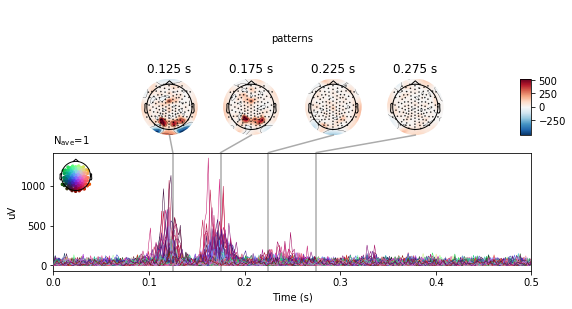

(125, 257)
top twenty channels:  [ 82  20  48  30  76 117  77  16  96  95  85  13  86  26 105  68  67 104
  53  57]
top twenty channels importances:  [0.00929983 0.00937874 0.00963876 0.01044492 0.01115044 0.01064985
 0.01063766 0.01061352 0.01138727 0.01470994 0.01472131 0.01182936
 0.01139814 0.01740188 0.01730713 0.02069681 0.01940333 0.01682855
 0.01656746 0.0136101 ]
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 1, 27: 0, 28: 0, 29: 0, 30: 1, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 1, 49: 0, 50: 0, 51: 0, 52: 0, 53: 1, 54: 0, 55: 0, 56: 0, 57: 1, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 1, 68: 1, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 1, 77: 1, 78: 0, 79: 0, 80: 0, 81: 0, 82: 1, 83: 0, 84: 0, 85: 1, 86: 1, 87: 0, 88: 0, 89: 0, 90: 

In [8]:
epo = mne.read_epochs(path)
ch_dict = do(epo,1)



Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_2_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8403 matching events found
Applying baseline correction (mode: mean)
Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_2_epo-1.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8403 matching events found
Applying baseline correction (mode: mean)
16806 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
shape of original epoch <EpochsFIF  |   16806 events (all good), 0 - 0.5 sec, baseline [0, 0], ~4.02 GB, data loaded,
 'AALL': 1545
 'AALN': 1494
 'AANL': 1599
 'AANN': 1494
 'AVLL': 1176
 'AVNN': 1497
 'VALL': 1251
 'VANN': 1437
 'VVLL': 1020
 'VVLN': 1662
 'VVNL': 1200
 'VVNN': 1431>
shape of features: (11445, 125, 257

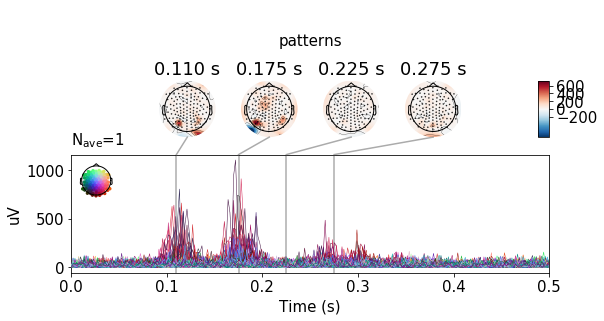

(125, 257)
top twenty channels:  [  1  85  77  14  57  37  31  82  26  48 105  53 117  67  96  68  78 122
  86 104]
top twenty channels importances:  [0.00922883 0.00978064 0.01066234 0.01019328 0.01034963 0.00989788
 0.0095552  0.01071433 0.01230208 0.01617072 0.02172072 0.01913796
 0.013954   0.01080729 0.01306435 0.01527353 0.01181152 0.01416758
 0.0133019  0.01395425]
{0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 1, 27: 0, 28: 0, 29: 0, 30: 0, 31: 1, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 1, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 1, 49: 0, 50: 0, 51: 0, 52: 0, 53: 1, 54: 0, 55: 0, 56: 0, 57: 1, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 1, 68: 1, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 1, 78: 1, 79: 0, 80: 0, 81: 0, 82: 1, 83: 0, 84: 0, 85: 1, 86: 1, 87: 0, 88: 0, 89: 0, 90: 

In [12]:
epo2 = mne.read_epochs(path2)
ch_dict2 = do(epo2,2,{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 1, 27: 0, 28: 0, 29: 0, 30: 1, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 1, 49: 0, 50: 0, 51: 0, 52: 0, 53: 1, 54: 0, 55: 0, 56: 0, 57: 1, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 1, 68: 1, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 1, 77: 1, 78: 0, 79: 0, 80: 0, 81: 0, 82: 1, 83: 0, 84: 0, 85: 1, 86: 1, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 1, 96: 1, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 1, 105: 1, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 1, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0})


Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_3_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
15132 matching events found
Applying baseline correction (mode: mean)
15132 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
shape of original epoch <EpochsFIF  |   15132 events (all good), 0 - 0.5 sec, baseline [0, 0], ~3.62 GB, data loaded,
 'AALL': 1377
 'AALN': 1251
 'AANL': 1422
 'AANN': 1077
 'AVLL': 1197
 'AVNN': 1134
 'VALL': 1131
 'VANN': 1491
 'VVLL': 1248
 'VVLN': 1134
 'VVNL': 1419
 'VVNN': 1251>
shape of features: (10179, 125, 257)
shape of target: (10179,)
(125, 257)
Accuracy on training set 1.000
Accuracy on test set 0.714


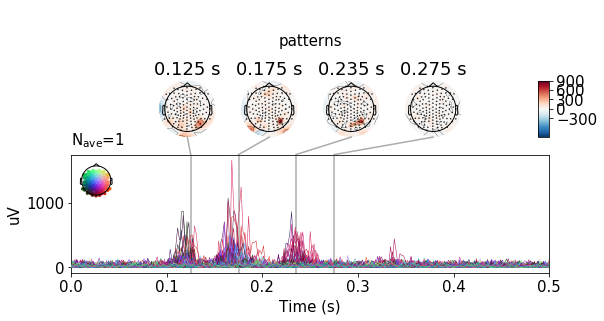

In [25]:
epo3 = mne.read_epochs(path3)
ch_dict3 = do(epo3,3,ch_dict2)

Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_4_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8385 matching events found
Applying baseline correction (mode: mean)
Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_4_epo-1.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8385 matching events found
Applying baseline correction (mode: mean)
16770 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
shape of original epoch <EpochsFIF  |   16770 events (all good), 0 - 0.5 sec, baseline [0, 0], ~4.01 GB, data loaded,
 'AALL': 1074
 'AALN': 1260
 'AANL': 1551
 'AANN': 1308
 'AVLL': 1551
 'AVNN': 1677
 'VALL': 1482
 'VANN': 1557
 'VVLL': 1431
 'VVLN': 1254
 'VVNL': 1437
 'VVNN': 1188>
shape of features: (10503, 125, 257

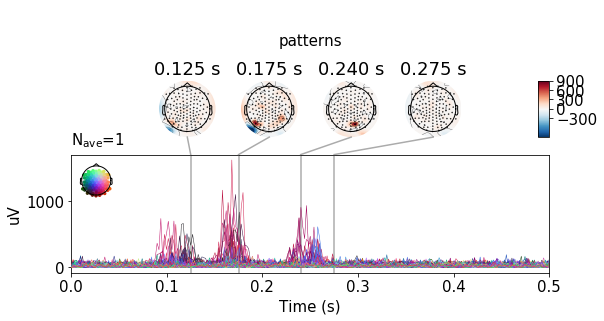

In [28]:
epo4 = mne.read_epochs(path4)
ch_dict4 = do(epo4,3,ch_dict3)

Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_5_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
15087 matching events found
Applying baseline correction (mode: mean)
15087 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
shape of original epoch <EpochsFIF  |   15087 events (all good), 0 - 0.5 sec, baseline [0, 0], ~3.61 GB, data loaded,
 'AALL': 1128
 'AALN': 1362
 'AANL': 1239
 'AANN': 1254
 'AVLL': 1299
 'AVNN': 984
 'VALL': 1356
 'VANN': 1293
 'VVLL': 1491
 'VVLN': 1059
 'VVNL': 1311
 'VVNN': 1311>
shape of features: (10155, 125, 257)
shape of target: (10155,)
(125, 257)
Accuracy on training set 1.000
Accuracy on test set 0.731


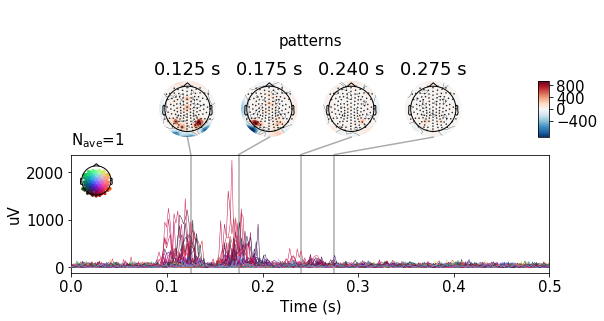

In [30]:
epo5 = mne.read_epochs(path5)
do(epo5,3)